Inspired by Ole Peters' [lovely blog post](https://ergodicityeconomics.com/2023/07/28/the-infamous-coin-toss/) about this game and ergodicity breaking, I wanted to dive a little deeper into the mathematics of this to deepen my understanding. This concept is deep and subtle, so this simple game is a good place to start.

# Description & Properties of the Game

This coin flip game goes as follows: each round a coin is flipped with probability $p$ of landing heads, and when it comes heads you get a return of $G$ and when it lands tails you get a return of $L$. In other words, each round with probability $p$ your wealth is multiplied by a factor of $1+G$ and with probability $1-p$ your wealth is multiplied by a factor of $1+L$.

We can then start working out some basic properties of this game.

First, given you've played $t$ rounds of the game, the probability that you win $w$ times is given by the binomial distribution:
$$
P(t, w; p) = {t \choose w} p^w (1-p)^{t-w}
$$

Next, given you have won $w$ times after player $t$ rounds, your terminal wealth is given by:
$$
R(t, w; G, L) = (1+G)^w (1+L)^{t-w}
$$
here, without loss of generality, we assume here that starting wealth is 1.

Now, what can we say about expected wealth of a player after $t$ rounds? Following Peters, we have to differentiate between what he calls the ensemble average and the time average. Let's start with the ensemble average. Here, this quantity matches what one usually thinks of when talking about mathematical expectation: multiply the probability of a game path by its terminal wealth. After $t$ rounds there are $t+1$ possible paths, each corresponding to the number of times a player could have won: $0$ to $t$ times. Now, given the above formulas, we can find this expectation, suppressing notation for the constant parameters $p$, $G$, and $L$:
$$
\text{EA}(t) = \mathbb{E}_W\left[R(t, w)\right] = \sum_{w=0}^t P(t, w) R(t, w)
$$

Let's consider the time average. As opposed to the ensemble average, which considers the possibilities over all possible paths, this average considers the expected behavior of a *single* path. We know from the properties of the binomial distribution that after $t$ rounds the expected number of wins is given by $pt$. So, for any single player, we expect that player to have won $pt$ times after playing for $t$ rounds. We can then work out this single players expected terminal wealth at that point:
$$
\text{TA}(t) = R(t, pt) = (1+G)^{pt} (1+L)^{t - pt} = ((1+G)^p (1+L)^{1-p})^t
$$

From this equation we can see that the term $(1+G)^p(1+L)^{1-p}$ determines the behavior of the time average as $t \to \infty$. If this term is $> 1$ then a player's wealth will tend towards $\infty$, if it's $=1$ then the player is expected to breakeven, and if it's $<1$ then the players wealth will tend towards 0. This means that we can determine, given either the loss or gain return, what the other must be so that the player is expected to break even. For example, given the winning return:
$$
(1+G)^p (1+L)^{1-p} = 1 \\
L = (1+G)^{\frac{-p}{1-p}} - 1
$$

# Ergodicity Breaking

The entire idea of ergodicity breaking comes from the differences between these two formulas, namely the fact that *they aren't equal*. The ensemble average can be interpreted as the average wealth of a group of players, as the number of people playing tends towards infinity. The time average, however, tells us what we expect the terminal wealth of any *single* player from that group to look like. In an ergodic system, these things are equal. This is to say that you can work out the properties of the entire system by following a single player, given enough time. However, that isn't the case here. The system as a whole has a different behavior than that of any single player. This isn't completely obvious from the formulas alone, but by running some game simulations, we can see how the ensemble and time averages diverge dramatically.

First, we can encode the equations defined above:

In [1]:
import numpy as np
from scipy.special import comb
from scipy import stats
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [2]:
def P(t, w, p):
    return comb(t, w) * p**w * (1 - p) ** (t - w)


def R(t, w, G, L):
    return (1 + G) ** w * (1 + L) ** (t - w)


def EA(t, G, L, p):
    sum = 0
    for w in range(t + 1):
        sum += P(t, w, p) * R(t, w, G, L)
    return sum

def TA(t, G, L, p):
    return ((1 + G) ** p * (1 + L) ** (1 - p)) ** t

Then we can simulate game paths. My approach here is to generate a sequence of integers uniformly from the set $\{0, 1\}$ and treat each $1$ as a win and each $0$ as a loss. The wealth over time is then simply given by the cumulative product of the respective gain/loss factors:

In [3]:
def sim_path(t, G, L, p):
    game_hist = rng.choice([1.0, 0.0], t, p=[p, 1 - p])
    game_hist[game_hist == 1] = 1 + G
    game_hist[game_hist == 0] = 1 + L
    return np.cumprod(game_hist)

Setting the gain return to $50\%$, the loss return to $-40\%$, and of course we'll treat this coin as fair so $p=0.5%$. We can then plot 50 different wealth paths after having played 1000 rounds of the game, along with our ensemble and time averages.

Text(0, 0.5, 'Terminal Wealth')

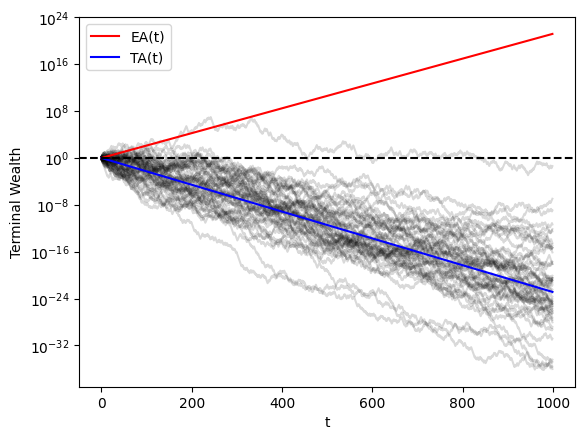

In [4]:
G = 0.5
L = -0.4
p = 0.5

plt.plot(
    np.array([sim_path(1000, G, L, p) for x in range(50)]).T, color="black", alpha=0.15
)
plt.plot([EA(t, G, L, p) for t in range(1000)], color="red", label="EA(t)")
plt.plot([TA(t, G, L, p) for t in range(1000)], color="blue", label="TA(t)")
plt.axhline(1, color="black", linestyle="dashed")
plt.yscale("log")
plt.legend()
plt.xlabel("t")
plt.ylabel("Terminal Wealth")

We can see right away the strangeness. All of the game paths end up losing money, following the negatively sloped time average line. However, the ensemble average tells us that the average wealth should be increasing! What gives? How can all of the players individually be expected to lose wealth over time, yet the ensemble average tells us that on the whole, the group should have increasing wealth? This is the insane mystery of ergodicity breaking.

# Going Deeper

Luckily for us, this game has simple mathematics, so we can get some nice theoretical results to shore up our intuition and understand what's going on here.

First of all, let's see how many wins we need to get so that we expect to at least break even, in other words, we want $w$ such that $R(t, w) \ge 1$. Doing some simple algebra, we can see that:
$$
w \ge -t \frac{\ln(1+L)}{\ln(1+G) - \ln(1+L)} \coloneqq w_{\text{BE}}
$$

From this we can work out the probability using the binominal distribution CDF, denoted $F$. Letting $W$ denote the random variable of how many wins we've got, we can see:
$$
\text{P}(W \ge w_{\text{BE}}) = 1 - F(w_{\text{BE}})
$$

We can plot this probability over $t$ as follows:

Text(0, 0.5, 'Probability')

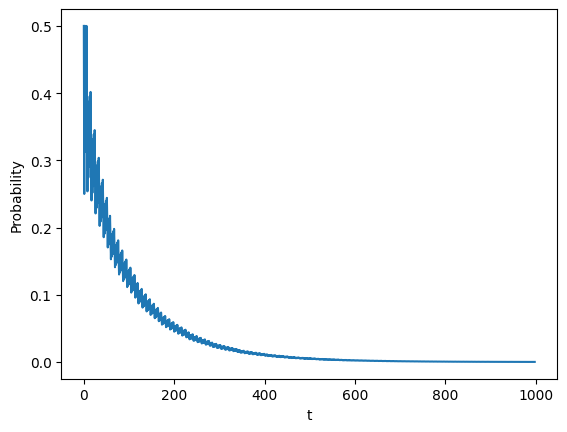

In [5]:
def w_BE(t, G, L):
    return -t * np.log(1 + L) / (np.log(1 + G) - np.log(1 + L))

plt.plot([1 - stats.binom.cdf(k=w_BE(n, G, L), n=n, p=p) for n in range(1, 1000)])
plt.xlabel("t")
plt.ylabel("Probability")

We can see that as $t$ increases, the probability of at least breaking even decreases to 0. This explains why our time average has negative slope: as you play more and more, the probability that you end up at least breaking even asymptotically approaches zero. However, this does not explain why our ensemble average has positive slope. Let's move to that next.

First, let's look at the average wealth of paths that *are* at least breaking even compared to the wealth of paths that are not. At a given time $t$, the function below computes the average wealth of all the possible game paths that are at or above break even, and the same for paths below break even.

Text(0, 0.5, 'Average Wealth')

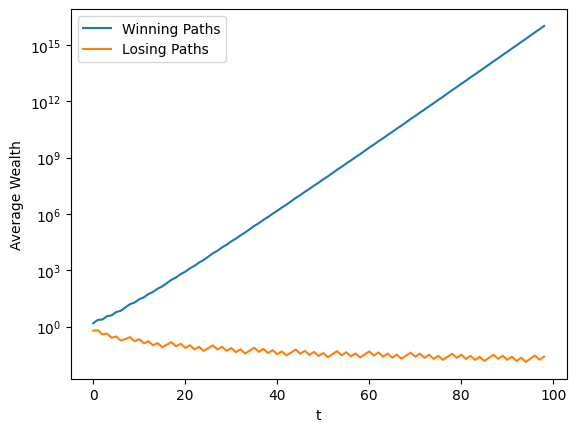

In [6]:
def calc_wealths(t, G, L):
    w_be = w_BE(t, G, L)
    winning_wealth = []
    losing_wealth = []
    for w in range(t + 1):
        if w < w_be:
            losing_wealth.append(R(t, w, G, L))
        else:
            winning_wealth.append(R(t, w, G, L))
    return np.mean(winning_wealth), np.mean(losing_wealth)

wealths = [calc_wealths(t, G, L) for t in range(1, 100)]

plt.plot([x[0] for x in wealths])
plt.plot([x[1] for x in wealths])
plt.legend(["Winning Paths", "Losing Paths"])
plt.yscale("log")
plt.xlabel("t")
plt.ylabel("Average Wealth")

We can see that the average wealth of winning paths is exponentially increasing (log-scale axes), while the average wealth of losing paths tends towards 0, as we would expect. This gives us a clue to the phenomena: the wealth of those winning paths is increasing *so quickly* that they are able to overcome the ever smaller probability of their occurrence, so when we aggregate them into the ensemble expectation, they alone are influential enough that it becomes positive. We can see this more clearly by looking at the relative contribution of each path to the ensemble average.

From $\text{EA}(t)$ we can see that it is the sum of the probability-weighted terminal wealth of each possible path. We can therefore compute the contribution of each term over the range of possible $w$ values, which is what we do below:

In [7]:
t = 100

results = []
for w in range(t+1):
    path_prob = P(t, w, p)
    path_wealth = R(t, w, G, L)
    results.append(path_prob * path_wealth)

Then, we can plot this curve, which we normalize so that each term is given as the percentage of the total, as well as include the line indicating the break-even number of wins $w_{\text{BE}}$ computed above:

Text(0, 0.5, '% of Total Expectation')

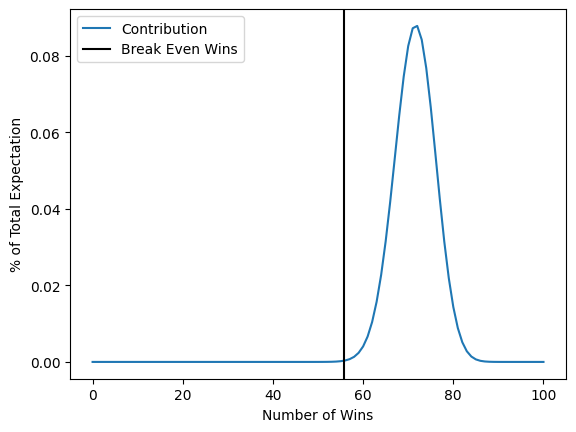

In [8]:
plt.plot(range(t+1), np.array(results) / np.sum(results))
plt.axvline(w_BE(t, G, L), color="black")
plt.legend(["Contribution", "Break Even Wins"])
plt.xlabel("Number of Wins")
plt.ylabel("% of Total Expectation")

Here, we can see that the paths that contribute the most to the ensemble average are the winning paths! This is what causes the ensemble average to be positive: the biggest contributors to it are those paths that have gained wealth.

One interesting thing about this graph is that it's not the paths that have won the absolute most that contribute heavily, but those that win just enough. Before I plotted this, I thought that the biggest contributors would be those paths with the largest number of wins, all the way to the right on the x-axis of this graph. The paths that say win more than 90% of the time have wealths that grow so exceptionally fast that I thought it would more than outweigh their exceptionally low probability of occurring. However, this is not the case!

It turns out that the probability-weighted terminal wealth simplifies nicely:
$$
P(t, w) R(t, w) = {t \choose w} p^w (1-p)^{t-w} (1+g)^w (1+L)^{t-w} \\
= {t \choose w} (p(1+G))^w ((1-p)(1+L))^{t-w}
$$
which looks very much like a rescaled binominal distribution. So, we can work out its mode in a very [similar way](https://math.stackexchange.com/questions/117926/finding-mode-in-binomial-distribution). This procedure gives us:
$$
w_\text{mode}(t) = \frac{(1-p)(1+L) - t p (1+G)}{-p(1+G) - (1-p)(1+L)}
$$
there is some subtlety around the fact that $w$ need be an integer that I'm ignoring here for simplicity. Regardless, we can add this line to our plot:

Text(0, 0.5, '% of Total Expectation')

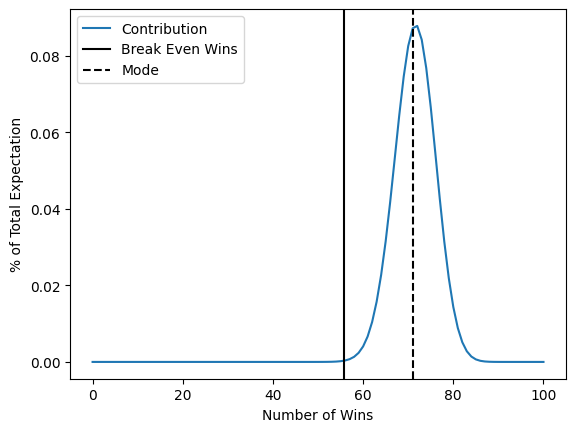

In [9]:
mode = ((1-p) * (1+L) - t * p * (1+G)) / (-p*(1+G) - (1-p)*(1+L))

plt.plot(range(t+1), np.array(results) / np.sum(results))
plt.axvline(w_BE(t, G, L), color="black")
plt.axvline(mode, linestyle="dashed", color="black")
plt.legend(["Contribution", "Break Even Wins", "Mode"])
plt.xlabel("Number of Wins")
plt.ylabel("% of Total Expectation")

We can go slightly further and convert this into a winning percentage by taking:
$$
\lim_{t \to \infty} \frac{w_\text{mode}(t)}{t} = \lim_{t \to \infty} \frac{(1-p)(1+L) - t p (1+G)}{-t p (1+G) - t (1-p)(1+L)}
= \lim_{t \to \infty} \frac{\frac{(1-p)(1+L) - t p (1+G)}{t} - p (1+G)}{-p(1+G) - (1-p)(1+L)} = \frac{p(1+G)}{p(1+G) + (1-p)(1+L)}
$$

In [10]:
peak_win_pct = (p * (1+G)) / (p*(1+G) + (1-p)*(1+L))
print(peak_win_pct)

0.7142857142857143


which is about 70% with our parameters. So, we can say that really it's the game paths that win around 70% of the time that are the ones that really push our ensemble average to be positive versus our time average.

Let's do one final exercise to see this effect a different way. We can compare the growth rates of the probability of a path and it's wealth. This function computes the cumulative percentage change of those quantities in log space, in other words, their geometric growth rate. We take absolute values here because for the values we consider probabilities are decreasing and wealths are increasing, and we want to compare them on the same scale.

In [11]:
def prb_wealth_curves(win_pct, p, G, L):
    prbs = []
    wealths = []
    for t in range(1, 250):
        w = win_pct * t
        prbs.append(P(t, w, p))
        wealths.append(R(t, w, G, L))

    prbs = np.array(prbs)
    wealths = np.array(wealths)

    return (
        np.abs(np.cumsum(np.diff(np.log(prbs), n=1))),
        np.abs(np.cumsum(np.diff(np.log(wealths), n=1)))
        )

First, we can look at these curve for the case where we win 70% of the time:

Text(0, 0.5, 'Cumulative Growth')

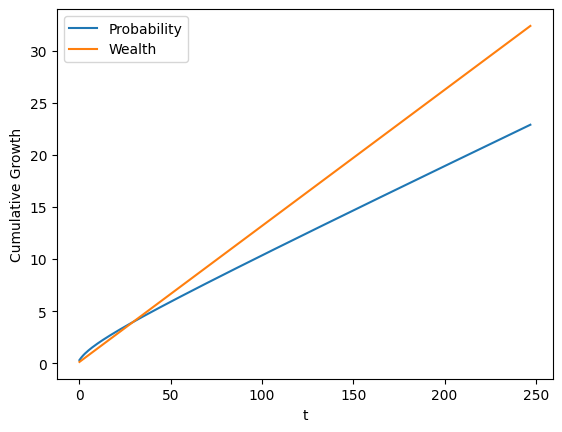

In [12]:
prbs, wealths = prb_wealth_curves(0.70, 0.5, G, L)

plt.plot(prbs)
plt.plot(wealths)
plt.legend(["Probability", "Wealth"])
plt.xlabel("t")
plt.ylabel("Cumulative Growth")

We see that at first, the probabilities are decreasing faster than wealth is increasing, but eventually wealth starts growing faster than the probabilities are decreasing, resulting in a large positive contribution to the ensemble average, as we saw above.

Now, let's look at paths that win 90% of the time:

Text(0, 0.5, 'Cumulative Growth')

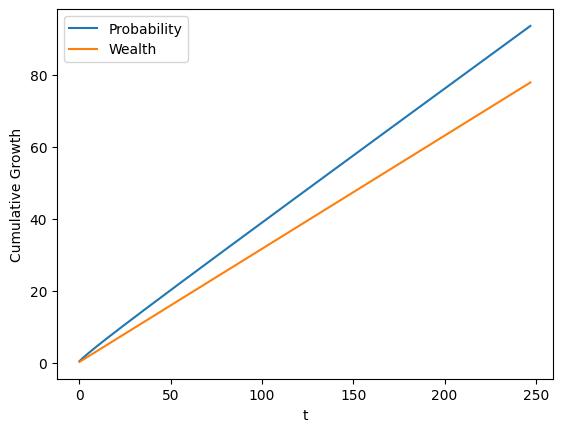

In [13]:
prbs, wealths = prb_wealth_curves(0.9, 0.5, G, L)

plt.plot(prbs)
plt.plot(wealths)
plt.legend(["Probability", "Wealth"])
plt.xlabel("t")
plt.ylabel("Cumulative Growth")

Here we can see that right away the probabilities are decreasing faster than wealths are increasing, and this relationship holds, and indeed becomes more extreme, as time progresses. This results in the small contribution to the ensemble average.

Now, in the case where we are winning below the break even rate, both the probabilities and wealths are decreasing, resulting in a contribution that shrinks very rapidly.

# Conclusion

This behavior is strange and very unintuitive to me, but it has enormous implications for how we think about many processes in the real world. Essentially, any process that follows a multiplicative reward structure will have this non-ergodic property. Notably, many economic systems have this kind of structure. Returns on capital are nearly always multiplicative: stock returns, GDP changes, certain gambling games, etcetera.

It's almost immediate to see how this idea relates to income inequality. An economic system can be growing when considered as a whole, but much of that aggregate growth is coming from the exceptionally huge gains of an increasingly smaller subset of the people as time progresses. Obviously, in the real world the situation is much more complicated, but the principle is there. It's interesting to think about the ultra-wealthy as nothing more than those people that happened to have gotten lucky with their investments compared to others. In fact, there is a noteworthy paper, "[Wealth condensation in a simple model of economy](https://arxiv.org/abs/cond-mat/0002374)," that talks about this effect.

Notably for financial economics, this exact same effect occurs if you move from discrete time to continuous time by analyzing Geometric Brownian Motion, and I'd like to get around to deriving how to move from a simple game like this to its continuous time counterpart. Stay tuned!